In [148]:
import numpy as np
from mnist.loader import MNIST
import matplotlib.pyplot as plt
import glob
import os
import h5py
import librosa
import umap
import soundfile as sf

from tqdm import tqdm
from pathlib import Path
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='poster')

sample_rate = 8000 #minimum 8000 for sf.write 

5 second clip splitter

In [149]:
def split(loaded_audio, file_name, clip_length = 5):
    chunk_samples = int(clip_length * sample_rate)
    chunks = [loaded_audio[i:i + chunk_samples] for i in range(0, len(loaded_audio), chunk_samples)]
    for i, chunk in enumerate(chunks): #thank u stack for this cool iterative
        output_file = f"fma_generated/{file_name}{i}.mp3"
        sf.write(output_file, chunk, sample_rate)
    
temp, _ = librosa.load('./fma_small/000/000002.mp3', sr=sample_rate)
temp = librosa.util.normalize(temp)
split(temp, '000002')

In [150]:
#total 8000 tracks
def load_batches(root_path, sample_rate, batch_size, clip_length = 5, output_dir='./fma_generated'):
    os.makedirs(output_dir, exist_ok=True)
    file_paths=[]
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith('.mp3'):
                file_paths.append(os.path.join(root, file))
                #print(file)
                
    np.random.seed(88)
    np.random.shuffle(file_paths)
    
    
    chunk_samples = int(clip_length * sample_rate) #actual number of samples per chunkclip
    
    
    file_index = 0
    batch_index = 0
    while file_index < len(file_paths):
        batch_clips=[]
        bathchs=[]
        while len(batch_clips)<batch_size and file_index < len(file_paths):
            file_path = file_paths[file_index]
            try:
                #print(f"processing {os.path.basename(file_path)}")
                
                audio, _ = librosa.load(file_path, sr=sample_rate)
                filename = os.path.splitext(os.path.basename(file_path))[0]
                
                clip_index = 0
                for i in range(0,len(audio), chunk_samples):
                    chunk = audio[i:i+chunk_samples]
                    
                    if len(chunk) == chunk_samples: #exactly 5 seconds
                        clip_filename = f"{filename}{clip_index:01d}.mp3" #single digit index :o
                        clip_path = os.path.join(output_dir, clip_filename)
                        
                        sf.write(clip_path, chunk, sample_rate)
                        batch_clips.append(chunk.copy()) #avoid ref issues
                        bathchs.append(clip_path)
                        clip_index += 1
                        
                        if len(batch_clips) >= batch_size:
                            break
            except Exception as e:
                #print(f"error loading {file_path}: {str(e)}")
                continue
            file_index+=1
        if len(batch_clips) > 0:
            print(f"batch {batch_index+1} with {len(batch_clips)} clips")
            
            yield batch_clips.copy(), bathchs.copy()
            del batch_clips, bathchs
            batch_index += 1
            
        else: break

In [151]:
def clear_generated(generated_dir='./fma_generated'):
    if os.path.exists(generated_dir):
        for file in tqdm(os.listdir(generated_dir)):
            if file.endswith('.mp3'):
                os.remove(os.path.join(generated_dir, file))
        os.rmdir(generated_dir)
        print(f"deleted absolutely everything within the following. directory. {generated_dir}")

In [152]:
clear_generated('./fma_generated')
batch_size = 5000 #how many clips, not how many files r processed. btw
big_data = load_batches('./fma_small', sample_rate, batch_size) #generator function
batches=[]
pathches=[]


small_data, file_paths = next(big_data)
batches.append(small_data)
pathches.append(file_paths)

  4%|▍         | 225/5006 [00:00<00:02, 2249.08it/s]

100%|██████████| 5006/5006 [00:01<00:00, 4657.60it/s]


deleted absolutely everything within the following. directory. ./fma_generated


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


batch 1 with 5000 clips


investigation.
https://stackoverflow.com/questions/65160046/librosa-does-not-normalize-wave-file-between-1-1

In [153]:
print(len(batches[0])) #first batch is 100 clips
print(len(batches[0][0])) #each clip is 30sec*5512 samples
print(batches[0][0]) #each sample 
print(np.mean(batches[0][0]))
print(np.std(batches[0][0]))

5000
40000
[ 1.9267792e-09  3.9689185e-09 -5.0188205e-09 ...  2.4918647e-01
  2.5008139e-01  1.9099995e-01]
-1.6623706e-06
0.124991134


choose either standardization or normalization. normalize for models
https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

In [154]:
import scipy
def into_freqs(audio, sample_rate):
    mel_spec=librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    #mel_db=librosa.power_to_db(mel_spec, ref=np.max) #scale to 1.0? perhaps??
    #librosa.display.specshow(mel_db, fmax=None, sr=sample_rate, x_axis='time', y_axis='mel')
    #plt.colorbar(format='%+2.0f dB')
    
    if mel_spec.max() == mel_spec.min():
        #i'm getting nans???
        return False
    
    #mel_normalized=2 * (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min()) - 1
    flattened = mel_spec.flatten()
    #mel_standardized = (mel_db - np.mean(mel_db)) / np.std(mel_db)
    #flattened = mel_standardized.flatten()
    return flattened

def into_textures(mel_spec, power = 2.0): #mel-frequency cepstrum
    if mel_spec is False or mel_spec is None:
        return False
    try: 
        logged = np.log(mel_spec + np.full_like(mel_spec, 1e-5))
        dct_powered = scipy.fft.dct(np.power(logged, power))
        normalized_textures = (dct_powered - np.mean(dct_powered)) / (np.std(dct_powered))
        return normalized_textures
    except Exception as e:
        print(f"{e}")
        return False


filtering out that one clip that's not the right length

In [155]:
batches_mels=[]
pathches_mels=[]
temp = []

print(f'initial lengths:\n batches[0]: {len(batches[0])} \n pathches[0]: {len(pathches[0])}')
for i, clip in enumerate(tqdm(batches[0], desc='into freqs processing')):
   mel_freqs = into_freqs(clip, sample_rate)
   if mel_freqs is False:
      print(f'failure at {i} spectrogram')
      temp.append(False)
      continue
   mel_texture = into_textures(mel_freqs)
   if mel_texture is False:
      print(f'failure at {i} texture')
      temp.append(False)
      continue
   temp.append(mel_texture)
   
batches_mels.append(temp)
pathches_mels.append(pathches[0])

lengths = [len(i) for i in batches_mels[0] if i is not False]
most_common_length = max(set(lengths), key=lengths.count)
filtered_paths = [path for mel, path in zip(batches_mels[0], pathches[0]) if mel is not False and len(mel) == most_common_length]
filtered_mels = [mel for mel in batches_mels[0] if mel is not False and len(mel) == most_common_length]

print(f"\nsummary!")
print(f"initial total: {len(batches[0])}")
print(f"filtered mels count: {len(filtered_mels)}")
print(f"filtered paths count: {len(filtered_paths)}")

batches_mels[0] = np.array(filtered_mels, dtype=np.float32)
pathches_mels[0] = filtered_paths

initial lengths:
 batches[0]: 5000 
 pathches[0]: 5000


into freqs processing:  27%|██▋       | 1367/5000 [00:05<00:13, 263.24it/s]

failure at 1334 spectrogram
failure at 1335 spectrogram


into freqs processing: 100%|██████████| 5000/5000 [00:22<00:00, 225.47it/s]



summary!
initial total: 5000
filtered mels count: 4998
filtered paths count: 4998


In [160]:
from sklearn.metrics.pairwise import cosine_similarity
import numba
import numpy as np

# @numba.njit()
# def norm(a):
#     return np.sqrt(sum(a[i]**2 for i in range(len(a))))

@numba.njit()
def scalable_dist(a, b):
    min_dist = np.inf
    for time_shift in range(-10, 10):
        for freq_shift in range (-10, 10):
            dist = used_dist(a, b, time_shift, freq_shift)
            if dist < min_dist:
                min_dist = dist
    
    return min_dist

@numba.njit()
def used_dist(a, b, time_shift, freq_shift):

    #a = a.astype(np.float32)
    #b = b.astype(np.float32)
    
    
    if time_shift > 0:
        a = a[time_shift:]
        b = b[:-time_shift]
    elif time_shift!=0:
        a = a[:(-time_shift)]
        b = b[-(-time_shift):]
    #print(f"{a.shape}, {b.shape}")
    if freq_shift>0:
        a = a[(128 * freq_shift):]
        b = b[:-(128 * freq_shift)]
    elif freq_shift!=0:
        a = a[:(-freq_shift)]
        b = b[-(-128 *freq_shift):]
    #print(f"{a.shape}, {b.shape}")
    
    #a = a.flatten()
    #b = b.flatten()
    
    #print(f"{a.shape}, {b.shape}")
    return np.linalg.norm(a - b)
    #return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))


#print(scalable_dist(np.array([1, 2, 3], dtype=np.float64),np.array([4, 5, 6], dtype=np.float64)))

In [ ]:
%%time
#print(batches_mels[0])
#print(len(batches_mels[0][0]))
unsup_embedding = umap.UMAP(n_neighbors=20, metric = 'euclidean').fit_transform(batches_mels[0])

/Users/user/Desktop/coding comps/transition/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



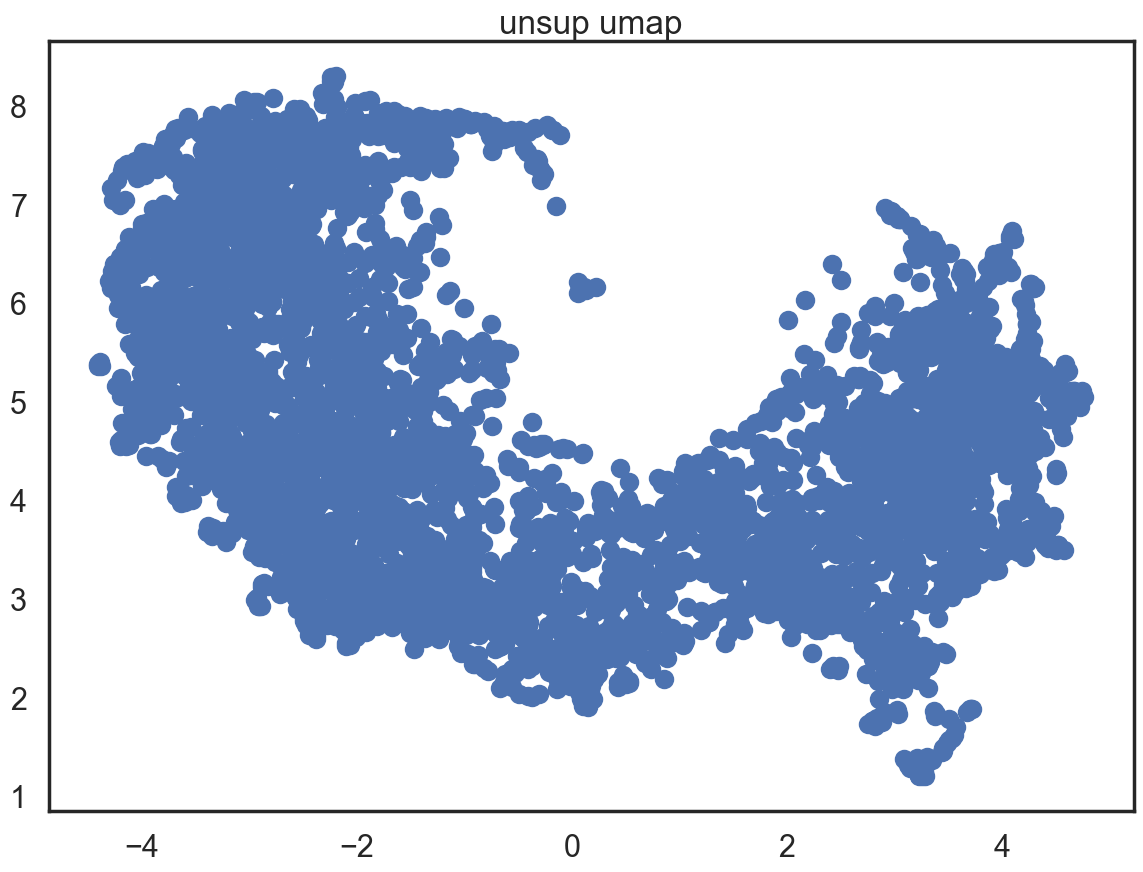

In [158]:
plt.figure(figsize=(14, 10))
plt.scatter(unsup_embedding[:,0], unsup_embedding[:, 1])
plt.title('unsup umap')
plt.show()

thank you gpt. i would never read all this documentation

In [159]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import os
import flask
import librosa
import numpy as np

# After your UMAP processing and filtering...
# Create DataFrame from your clip data
def create_clip_dataframe(umap_embedding, filtered_paths):
    """
    Create DataFrame for clips instead of full audio files
    """
    df = pd.DataFrame({
        'UMAP1': umap_embedding[:, 0],
        'UMAP2': umap_embedding[:, 1], 
        'Clip_Path': filtered_paths,
        'Original_File': [extract_original_filename(path) for path in filtered_paths],
        'Clip_Index': [extract_clip_index(path) for path in filtered_paths]
    })
    
    # Create audio URLs for serving
    df['audio_url'] = df['Clip_Path'].apply(get_clip_audio_url)
    
    return df

def extract_original_filename(clip_path):
    """Extract original filename from clip path"""
    # ./fma_generated/000002_clip_000.mp3 -> 000002
    basename = os.path.basename(clip_path)
    # Remove extension and clip suffix
    name_without_ext = os.path.splitext(basename)[0]
    # Split on '_clip_' and take first part
    if '_clip_' in name_without_ext:
        return name_without_ext.split('_clip_')[0]
    return name_without_ext

def extract_clip_index(clip_path):
    """Extract clip index from clip path"""
    # ./fma_generated/000002_clip_000.mp3 -> 0
    basename = os.path.basename(clip_path)
    name_without_ext = os.path.splitext(basename)[0]
    if '_clip_' in name_without_ext:
        try:
            return int(name_without_ext.split('_clip_')[1])
        except (ValueError, IndexError):
            return 0
    return 0

def get_clip_audio_url(clip_path):
    """Convert clip path to URL for serving"""
    # ./fma_generated/000002_clip_000.mp3 -> /audio/000002_clip_000.mp3
    filename = os.path.basename(clip_path)
    return f'/audio/{filename}'

# Create your DataFrame
df = create_clip_dataframe(unsup_embedding, filtered_paths)

# Initialize Dash app
app = dash.Dash(__name__)

# Set up audio serving directory (your generated clips)
AUDIO_DIR = os.path.abspath('fma_generated')  # Changed from 'fma_small' to 'fma_generated'

@app.server.route('/audio/<path:filename>')
def serve_audio(filename):
    """Serve audio clips from fma_generated directory"""
    if '..' in filename or filename.startswith('/'):
        flask.abort(404)
    return flask.send_from_directory(AUDIO_DIR, filename)

# Create the scatter plot
fig = px.scatter(
    df, 
    x="UMAP1", 
    y="UMAP2", 
    hover_data=["Original_File", "Clip_Index"], 
    custom_data=['audio_url'],
    title="Audio Clips UMAP Visualization",
    labels={'UMAP1': 'UMAP Dimension 1', 'UMAP2': 'UMAP Dimension 2'}
)

# Update hover template to show clip info
fig.update_traces(
    hovertemplate="<b>Original File:</b> %{customdata[1]}<br>" +
                  "<b>Clip Index:</b> %{customdata[2]}<br>" +
                  "<b>UMAP1:</b> %{x}<br>" +
                  "<b>UMAP2:</b> %{y}<extra></extra>"
)

app.layout = html.Div([
    #html.H1("analysis", style={'textAlign': 'center'}),
    #html.P(f"this many!!! {len(df)} audio clips", style={'textAlign': 'center'}),
    dcc.Graph(id="scatter", figure=fig),
    html.Div([
        html.Audio(id='audio-player', controls=True, src=''),
        html.Div(id='clip-info', style={'marginTop': '10px'})
    ], style={'margin': '20px'})
])

@app.callback(
    [Output('audio-player', 'src'),
     Output('clip-info', 'children')],
    Input('scatter', 'clickData')
)
def update_audio(clickData):
    if clickData and "points" in clickData:
        audio_url = clickData["points"][0]["customdata"][0]
        
        # Get point index to show clip info
        point_idx = clickData["points"][0]["pointIndex"]
        clip_info = html.Div([
            html.P(f"file path: {df.iloc[point_idx]['Original_File']}{df.iloc[point_idx]['Clip_Index']:01d}.mp3"),
            html.P(f"({df.iloc[point_idx]['UMAP1']:.3f}, {df.iloc[point_idx]['UMAP2']:.3f})")
        ])
        
        return audio_url, clip_info
    
    return '', html.P("")

if __name__ == "__main__":
    print(f"Serving {len(df)} audio clips")
    print(f"Audio files served from: {AUDIO_DIR}")
    app.run(debug=True) 

Serving 4998 audio clips
Audio files served from: /Users/user/Desktop/coding comps/transition/fma_generated
